### import

In [88]:
import numpy as np
#from scipy import stats
import matplotlib.pyplot as plt
import matplotlib

import torch 
from torch import distributions
from torch import nn
from torch.utils import data

### MCMC

In [89]:
class MetropolisGauss(object):
    def __init__(self, model, x0, temperature=1.0, noise=0.1,
                 burnin=0, stride=1, nwalkers=1, mapper=None):
        """ Metropolis Monte-Carlo Simulation with Gaussian Proposal Steps
        Parameters
        ----------
        model : Energy model
            Energy model object, must provide the function energy(x)
        x0 : [array]
            Initial configuration
        noise : float
            Noise intensity, standard deviation of Gaussian proposal step
        temperatures : float or array
            Temperature. By default (1.0) the energy is interpreted in reduced units.
            When given an array, its length must correspond to nwalkers, then the walkers
            are simulated at different temperatures.
        burnin : int
            Number of burn-in steps that will not be saved
        stride : int
            Every so many steps will be saved
        nwalkers : int
            Number of parallel walkers
        mapper : Mapper object
            Object with function map(X), e.g. to remove permutation.
            If given will be applied to each accepted configuration.
        """
        self.model = model
        self.noise = noise
        self.temperature = temperature
        self.burnin = burnin
        self.stride = stride
        self.nwalkers = nwalkers
        if mapper is None:
            class DummyMapper(object):
                def map(self, X):
                    return X
            mapper = DummyMapper()
        self.mapper = mapper
        self.reset(x0)

    def _proposal_step(self):
        # proposal step
        self.x_prop = self.x + self.noise*np.random.randn(self.x.shape[0], self.x.shape[1])
        self.x_prop = self.mapper.map(self.x_prop)
        self.E_prop = self.model.energy(self.x_prop)

    def _acceptance_step(self):
        # acceptance step
        acc = -np.log(np.random.rand()) > (self.E_prop - self.E) / self.temperature
        self.x = np.where(acc[:, None], self.x_prop, self.x)
        self.E = np.where(acc, self.E_prop, self.E)

    def reset(self, x0):
        # counters
        self.step = 0
        self.traj_ = []
        self.etraj_ = []

        # initial configuration
        self.x = np.tile(x0, (self.nwalkers, 1))
        self.x = self.mapper.map(self.x)
        self.E = self.model.energy(self.x)

        # save first frame if no burnin
        if self.burnin == 0:
            self.traj_.append(self.x)
            self.etraj_.append(self.E)

    @property
    def trajs(self):
        """ Returns a list of trajectories, one trajectory for each walker """
        T = np.array(self.traj_).astype(np.float32)
#        return T
        return [T[:, i, :] for i in range(T.shape[1])]

    @property
    def traj(self):
        return self.trajs[0]

    @property
    def etrajs(self):
        """ Returns a list of energy trajectories, one trajectory for each walker """
        E = np.array(self.etraj_)
        return [E[:, i] for i in range(E.shape[1])]

    @property
    def etraj(self):
        return self.etrajs[0]

    def run(self, nsteps=1, verbose=0):
        for i in range(nsteps):
            self._proposal_step()
            self._acceptance_step()
            self.step += 1
            if verbose > 0 and i % verbose == 0:
                print('Step', i, '/', nsteps)
            if self.step > self.burnin and self.step % self.stride == 0:
                self.traj_.append(self.x)
                self.etraj_.append(self.E)

### model

In [90]:
def ensure_traj(X):
    if np.ndim(X) == 2:
        return X
    if np.ndim(X) == 1:
        return np.array([X])
    raise ValueError('Incompatible array with shape: ', np.shape(X))

In [91]:
def distance_matrix_squared(crd1, crd2, dim=2):
    """ Returns the distance matrix or matrices between particles
    Parameters
    ----------
    crd1 : array or matrix
        first coordinate set
    crd2 : array or matrix
        second coordinate set
    dim : int
        dimension of particle system. If d=2, coordinate vectors are [x1, y1, x2, y2, ...]
    """
    crd1 = ensure_traj(crd1)
    crd2 = ensure_traj(crd2)
    n = int(np.shape(crd1)[1]/dim)

    crd1_components = [np.tile(np.expand_dims(crd1[:, i::dim], 2), (1, 1, n)) for i in range(dim)]
    crd2_components = [np.tile(np.expand_dims(crd2[:, i::dim], 2), (1, 1, n)) for i in range(dim)]
    D2_components = [(crd1_components[i] - np.transpose(crd2_components[i], axes=(0, 2, 1)))**2 for i in range(dim)]
    D2 = np.sum(D2_components, axis=0)
    return D2

In [92]:
class ParticleDimer(object):

    params_default = {
        'nsolvent' : 1,
        'eps' : 1.0,  # LJ prefactor
        'rm' : 1.1,  # LJ particle size
        'dimer_slope' : 0.0,  # dimer slope parameter
        #'dimer_slope' : -0.5,  # dimer slope parameter
        'dimer_a' : 25.0,  # dimer x2 parameter
        'dimer_b' : 10.0,  # dimer x4 parameter
        'dimer_dmid' : 1.5,  # dimer transition state distance
        'dimer_k' : 20.0,  # dimer force constant
        'box_halfsize' : 3.0,
        'box_k' : 100.0,  # box repulsion force constant
        'grid_k' : 0.0,  # restraint strength to particle grid (to avoid permutation)
        }

    def __init__(self, params=None):
        # set parameters
        if params is None:
            params = self.__class__.params_default
        self.params = params

        # useful variables
        self.nparticles = params['nsolvent'] + 2
        self.dim = 2 * self.nparticles

        # create mask matrix to help computing particle interactions
        self.mask_matrix = np.ones((self.nparticles, self.nparticles), dtype=np.float32)
        self.mask_matrix[0, 1] = 0.0
        self.mask_matrix[1, 0] = 0.0
        for i in range(self.nparticles):
            self.mask_matrix[i, i] = 0.0

        # save grid to compute position restraints
        self.grid = self.init_positions(params['dimer_dmid'])


    # initialization
    def init_positions(self, dimer_distance, scaling_factor=1.05):
        """ Initializes particles positions in a box
        Parameters:
        -----------
        dimer_distance : float
            initial dimer distance
        scaling_factor : float
            scaling factor to be applied to the configuration
        """
        # dimer
        pos = []
        pos.append(np.array([-0.5*dimer_distance, 0]))
        pos.append(np.array([0.5*dimer_distance, 0]))
        # solvent particles
        sqrtn = int(np.sqrt(self.params['nsolvent']))
        locs = np.linspace(-self.params['box_halfsize']-1, self.params['box_halfsize']+1, sqrtn+2)[1:-1]
        for i in range(0, sqrtn):
            for j in range(0, sqrtn):
                pos.append(np.array([locs[i], locs[j]]))
        pos = np.array(pos).reshape((1, 2*(self.params['nsolvent']+2)))
        return scaling_factor * pos

    def draw_config(self, x, axis=None, dimercolor='blue', alpha=0.7):
        import matplotlib.pyplot as plt
        from matplotlib.patches import Rectangle, Circle

        # prepare data
        X = x.reshape(((self.params['nsolvent']+2), 2))
        # set up figure
        if axis is None:
            plt.figure(figsize=(5, 5))
            axis = plt.gca()
        #fig, ax = plt.subplots(figsize=(5, 5))
        d = self.params['box_halfsize']
        axis.set_xlim((-d, d))
        axis.set_ylim((-d, d))
        # draw box
        axis.add_patch(Rectangle((-d-self.params['rm'], -d-self.params['rm']),
                                 2*d+2*self.params['rm'], 0.5*self.params['rm'], color='lightgrey', linewidth=0))
        axis.add_patch(Rectangle((-d-self.params['rm'], d+0.5*self.params['rm']),
                                 2*d+2*self.params['rm'], 0.5*self.params['rm'], color='lightgrey', linewidth=0))
        axis.add_patch(Rectangle((-d-self.params['rm'], -d-self.params['rm']),
                                 0.5*self.params['rm'], 2*d+2*self.params['rm'], color='lightgrey', linewidth=0))
        axis.add_patch(Rectangle((d+0.5*self.params['rm'], -d-self.params['rm']),
                                 0.5*self.params['rm'], 2*d+2*self.params['rm'], color='lightgrey', linewidth=0))
        # draw solvent
        circles = []
        for x in X[2:]:
            circles.append(axis.add_patch(Circle(x, radius=0.5*self.params['rm'],
                                                 linewidth=2, edgecolor='black', facecolor='grey', alpha=alpha)))
        # draw dimer
        circles.append(axis.add_patch(Circle(X[0], radius=0.5*self.params['rm'],
                                             linewidth=2, edgecolor='black', facecolor=dimercolor, alpha=alpha)))
        circles.append(axis.add_patch(Circle(X[1], radius=0.5*self.params['rm'],
                                             linewidth=2, edgecolor='black', facecolor=dimercolor, alpha=alpha)))
        #plot(X[:, 0], X[:, 1], linewidth=0, marker='o', color='black')
        axis.set_xlim(-4, 4)
        axis.set_ylim(-4, 4)
        axis.set_xticks([])
        axis.set_yticks([])
        #return(fig, ax, circles)

    # ANIMATE
    #def animate(i):
    #    X = traj1[i].reshape(n+2, 2)
    #    for i, x in enumerate(X):
    #        circles[i].center = x
    #    return circles

    def dimer_distance(self, x):
        return np.sqrt((x[:, 2] - x[:, 0])**2 + (x[:, 3] - x[:, 1])**2)

#    def dimer_distance_tf(self, x):
#        return tf.sqrt((x[:, 2] - x[:, 0])**2 + (x[:, 3] - x[:, 1])**2)

    def _distance_squared_matrix(self, crd1, crd2):
        return distance_matrix_squared(crd1, crd2, dim=2)

    def LJ_energy(self, x):
        # all component-wise distances bet
        batchsize = np.shape(x)[0]
        D2 = self._distance_squared_matrix(x, x)
        mmatrix = np.tile(np.expand_dims(self.mask_matrix, 0), (batchsize, 1, 1))
        D2 = D2 + (1.0 - mmatrix)  # this is just to avoid NaNs, the inverses will be set to 0 later
        D2rel = (self.params['rm']**2) / D2
        # remove self-interactions and interactions between dimer particles
        D2rel = D2rel * mmatrix
        # energy
        E = 0.5*self.params['eps']*np.sum(D2rel**6, axis=(1, 2))  # do 1/2 because we have double-counted each interaction
        return E
    
    def dimer_energy_distance(self, d):
        d0 = 2 * (d - self.params['dimer_dmid'])
        d2 = d0*d0
        d4 = d2*d2
        energy_interaction = self.params['dimer_slope']*d0 - self.params['dimer_a']*d2 + self.params['dimer_b']*d4
        return energy_interaction
    
    def dimer_energy(self, x):
        # center restraint energy
        energy_dx = self.params['dimer_k']*(x[:, 0] + x[:, 2])**2
        # y restraint energy
        energy_dy = self.params['dimer_k']*(x[:, 1])**2 + self.params['dimer_k']*(x[:, 3])**2
        # first two particles
        d = np.sqrt((x[:, 0]-x[:, 2])**2 + (x[:, 1]-x[:, 3])**2)
        d0 = 2 * (d - self.params['dimer_dmid'])
        d2 = d0*d0
        d4 = d2*d2
        energy_interaction = self.params['dimer_slope']*d0 - self.params['dimer_a']*d2 + self.params['dimer_b']*d4

        return energy_dx + energy_dy + energy_interaction

    def box_energy(self, x):
        xcomp = x[:, 0::2]
        ycomp = x[:, 1::2]
        # indicator functions
        E = 0.0
        d_left = -(xcomp + self.params['box_halfsize'])
        E += np.sum((np.sign(d_left) + 1) * self.params['box_k'] * d_left**2, axis=1)
        d_right = (xcomp - self.params['box_halfsize'])
        E += np.sum((np.sign(d_right) + 1) * self.params['box_k'] * d_right**2, axis=1)
        d_down = -(ycomp + self.params['box_halfsize'])
        E += np.sum((np.sign(d_down) + 1) * self.params['box_k'] * d_down**2, axis=1)
        d_up = (ycomp - self.params['box_halfsize'])
        E += np.sum((np.sign(d_up) + 1) * self.params['box_k'] * d_up**2, axis=1)
        return E


    def grid_energy(self, x):
        d2 = (x - self.grid)**2
        E = np.sum(self.params['grid_k'] * (self.params['rm']**2 * d2) ** 6, axis=1)
        return E

    def _energy(self, x):
        return self.LJ_energy(x) + self.dimer_energy(x) + self.box_energy(x) + self.grid_energy(x)

    def energy(self, x):
        if x.shape[0] < 10000:
            return self._energy(x)
        else:
            energy_x = np.zeros(x.shape[0])
            for i in range(0, len(energy_x), 10000):
                i_from = i
                i_to = min(i_from + 10000, len(energy_x))
                energy_x[i_from:i_to] = self._energy(x[i_from:i_to])
            return energy_x

    def plot_dimer_energy(self, axis=None):
        """ Plots the dimer energy to the standard figure """
        x_scan = np.linspace(0.5, 2.5, 100)
        E_scan = self.dimer_energy(np.array([1.5-0.5*x_scan, np.zeros(100), 1.5+0.5*x_scan, np.zeros(100)]).T)
        E_scan -= E_scan.min()

        if axis is None:
            axis = plt.gca()
        #plt.figure(figsize=(5, 4))
        axis.plot(x_scan, E_scan, linewidth=2)
        axis.set_xlabel('x / a.u.')
        axis.set_ylabel('Energy / kT')
        axis.set_ylim(E_scan.min() - 2.0, E_scan[int(E_scan.size / 2)] + 2.0)

        return x_scan, E_scan

### data

In [93]:
def plot_trajectory(etraj, traj):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].plot(etraj)
    axes[0].set_xlabel('timestep')
    axes[0].set_ylabel('energy')
    dtraj = np.sqrt((traj[:, 2] - traj[:, 0])**2 + (traj[:, 3] - traj[:, 1])**2)
    axes[1].plot(dtraj)
    axes[1].set_xlabel('timestep')
    axes[1].set_ylabel('dimer distance')    
    plt.tight_layout()
    return dtraj

In [94]:
model = ParticleDimer()

In [95]:
nsteps = 500000
stride = 10
noise=0.02
burnin=100000
d_closed = 1.0
d_open = 2.0

array([2.0254812, 2.0957403, 2.128286 , ..., 2.0409234, 2.0964081,
       2.0766456], dtype=float32)

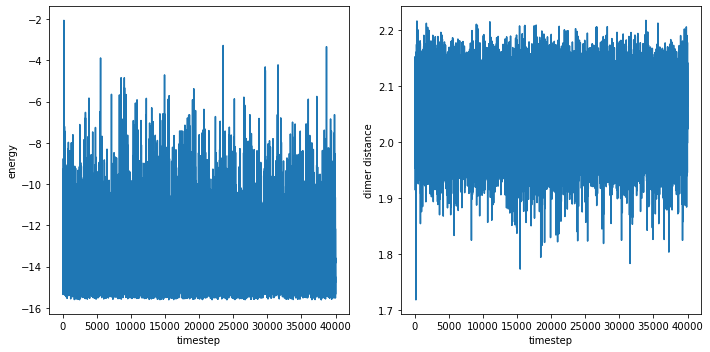

In [96]:
# sample closed
x0 = model.init_positions(d_closed)
sampler_closed = MetropolisGauss(model, x0, noise=noise, burnin=burnin, stride=stride)
sampler_closed.run(nsteps)
plot_trajectory(sampler_closed.etraj, sampler_closed.traj)

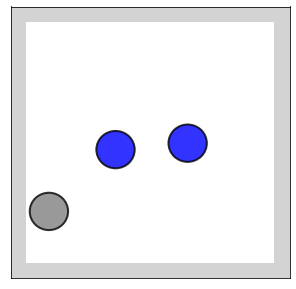

In [97]:
model.draw_config(sampler_closed.traj[-1], dimercolor='blue', alpha=0.8);

array([2.0626352, 2.0318897, 2.0530849, ..., 2.0764751, 2.0317504,
       2.0286236], dtype=float32)

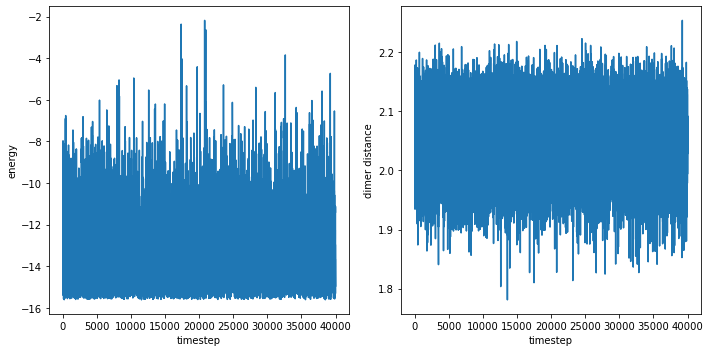

In [98]:
# sample open
x0 = model.init_positions(d_open)
sampler_open = MetropolisGauss(model, x0, noise=noise, burnin=burnin, stride=stride)
sampler_open.run(nsteps)
plot_trajectory(sampler_open.etraj, sampler_open.traj)

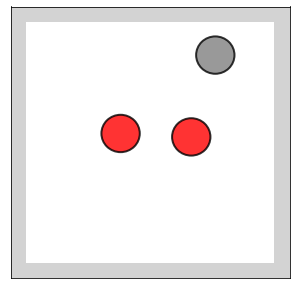

In [99]:
model.draw_config(sampler_open.traj[-1], dimercolor='red', alpha=0.8)

In [100]:
x_open=sampler_open.traj
x_closed=sampler_closed.traj
x_open_dis=model.dimer_distance(x_open)
x_closed_dis=model.dimer_distance(x_closed)

In [101]:
x_brute=np.vstack((x_open,x_closed))
x_brute_dis=model.dimer_distance(x_brute)
x_brute.shape

(80000, 6)

In [102]:
def plot_dimer_energy_with_data(model, x, axis=None):
    counts, bins = np.histogram(x, bins = 200 )
    anchors = (bins[1:] + bins[:-1]) / 2
    probs = counts / np.sum(counts)

    anchors = anchors[np.where(probs > 0.0001)]
    probs = probs[np.where(probs > 0.0001)]

    f = -np.log(probs)
    fn = f - np.min(f)
    plt.scatter(anchors, fn)  
    """ Plots the dimer energy to the standard figure """
    d_scan = np.linspace(0.5, 2.5, 100)
    E_scan = model.dimer_energy_distance(d_scan)
    E_scan -= E_scan.min()

    if axis is None:
        axis = plt.gca()
    #plt.figure(figsize=(5, 4))
    axis.plot(d_scan, E_scan, linewidth=2)
    axis.set_xlabel('x / a.u.')
    axis.set_ylabel('Energy / kT')
    axis.set_ylim(E_scan.min() - 2.0, E_scan[int(E_scan.size / 2)] + 2.0)


    return d_scan, E_scan

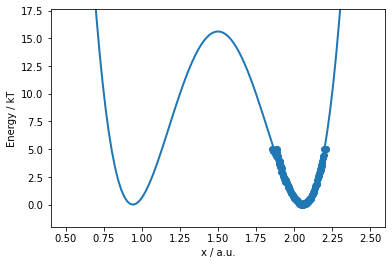

In [103]:
x,E=plot_dimer_energy_with_data(model,x_open_dis)

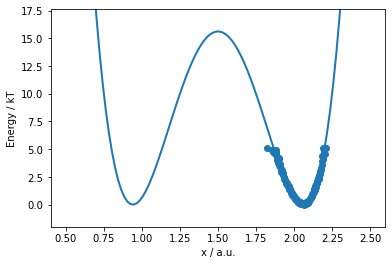

In [104]:
x,E=plot_dimer_energy_with_data(model,x_closed_dis)

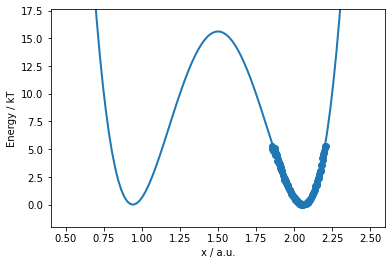

In [105]:
x,E=plot_dimer_energy_with_data(model,x_brute_dis)

Text(0, 0.5, 'Probability')

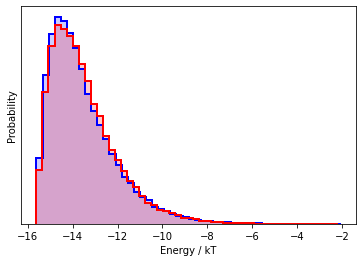

In [106]:
plt.hist(sampler_closed.etraj, 50, histtype='stepfilled', color='blue', alpha=0.2);
plt.hist(sampler_closed.etraj, 50, histtype='step', color='blue', linewidth=2);
plt.hist(sampler_open.etraj, 50, histtype='stepfilled', color='red', alpha=0.2);
plt.hist(sampler_open.etraj, 50, histtype='step', color='red', linewidth=2);
plt.xlabel('Energy / kT')
plt.yticks([])
plt.ylabel('Probability')

Text(0.5, 0, 'Probability')

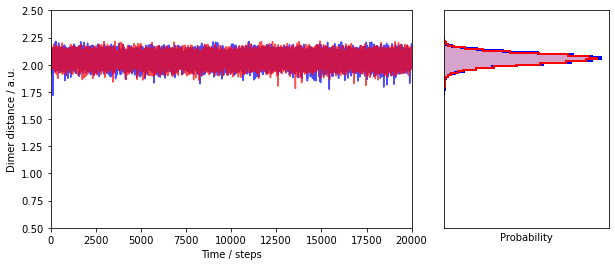

In [107]:
plt.figure(figsize=(10, 4))
ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 3), (0, 2))
ax1.plot(model.dimer_distance(sampler_closed.traj), color='blue', alpha=0.7)
ax1.plot(model.dimer_distance(sampler_open.traj), color='red', alpha=0.7)
ax1.set_xlim(0, 20000)
ax1.set_ylim(0.5, 2.5)
ax1.set_xlabel('Time / steps')
ax1.set_ylabel('Dimer distance / a.u.')
ax2.hist(model.dimer_distance(sampler_closed.traj), 30, orientation='horizontal', histtype='stepfilled', color='blue', alpha=0.2);
ax2.hist(model.dimer_distance(sampler_closed.traj), 30, orientation='horizontal', histtype='step', color='blue', linewidth=2);
ax2.hist(model.dimer_distance(sampler_open.traj), 30, orientation='horizontal', histtype='stepfilled', color='red', alpha=0.2);
ax2.hist(model.dimer_distance(sampler_open.traj), 30, orientation='horizontal', histtype='step', color='red', linewidth=2);
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_ylim(0.5, 2.5)
ax2.set_xlabel('Probability')

In [109]:
np.save('dimer_data\dimer_data_1p',x_brute)